In [1]:
from helpers import ImageManager
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from sklearn.decomposition import PCA

In [2]:
def plot(dim, figsize, imgs, titles, gray=False):    
    fig, ax = plt.subplots(dim[0], dim[1], figsize=figsize)
    ax = ax.flatten()
    for i in range(len(imgs)):
        if gray:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i])
        ax[i].set_title(titles[i]), ax[i].set_xticks([]), ax[i].set_yticks([])

In [3]:
# Get Data using the Helper Class
mng = ImageManager()
testing_images = mng.get_testing_images(color=cv2.COLOR_BGR2GRAY)
training_images = mng.get_training_images(color=cv2.COLOR_BGR2GRAY)
_, _ = mng.update_testing_bounds()
_, _ = mng.update_training_bounds()
testing_faces = mng.testing_faces
training_faces = mng.training_faces

In [4]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

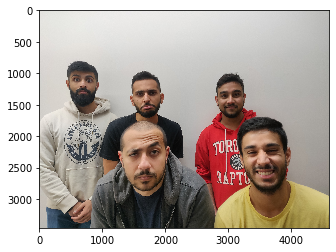

In [5]:
image = cv2.imread('images/group/5.jpg')
# image = training_images[10]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.2,
    minNeighbors=6,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)

Found 5 faces!


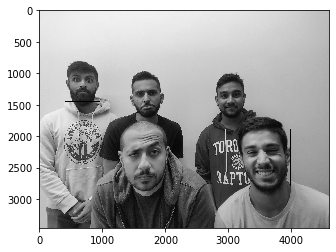

In [6]:
print("Found {0} faces!".format(len(faces)))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)

# fig, ax = plt.figure()
plt.imshow(gray, 'gray')
# cv2.imwrite('logs/img.jpg', image)

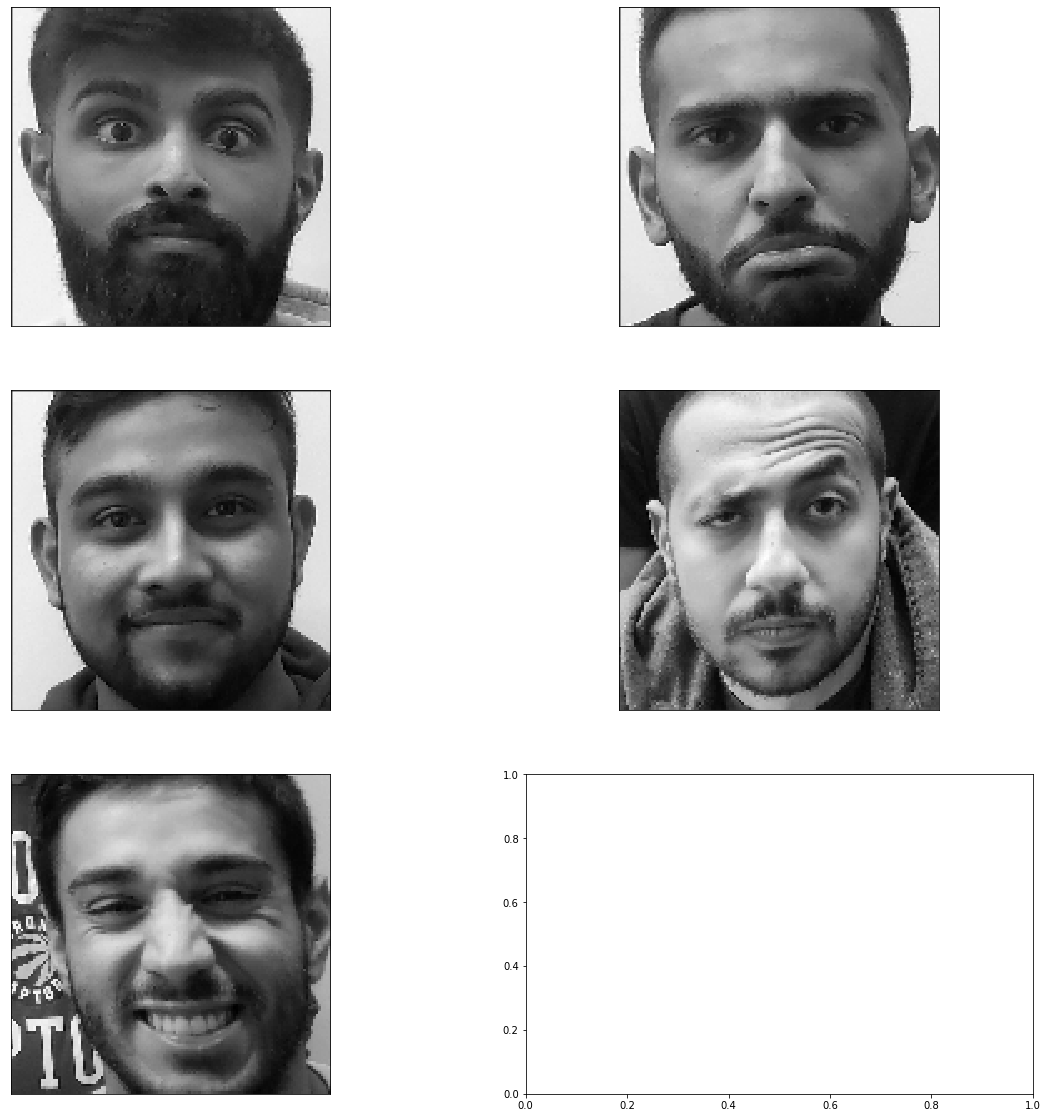

In [7]:
extracted_faces = mng.extract_faces(gray, faces)
plot((3, 2), (20, 20), extracted_faces, [""]*len(faces), gray=True)

# PCA

In [8]:
# Number of Features/Eigenfaces used in PCA (optimized)
NC = 15

In [24]:
extracted_faces.pop(2)
# plt.imshow(extracted_faces[2])

array([[ 85, 126, 127, ..., 122, 122, 122],
       [127, 192, 191, ..., 183, 184, 183],
       [127, 191, 192, ..., 184, 185, 184],
       ...,
       [117, 177, 177, ...,  30,  33,  35],
       [118, 178, 177, ...,  28,  34,  33],
       [117, 177, 177, ...,  37,  34,  33]], dtype=uint8)

In [25]:
X_train = np.array([i.flatten() for i in training_faces])
pca = PCA(n_components=NC)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
# plt.imshow(pca.mean_.reshape(training_faces[0].shape), cmap='gray')
# plt.title('Train Dataset - Mean Image');

In [27]:
len(extracted_faces)

4

In [28]:
X_test = np.array([i.flatten() for i in extracted_faces])
X_test_pca = pca.transform(X_test)

In [33]:
# Creating labels for team members
labels = {0:'abdullah', 1:'mustafa', 2:'saleh', 3:'adham'}

# Creating correct labels for test set
y_test = np.array([[0]*1, [2]*1, [3]*1, [1]*1]).flatten()
# Creating correct labels for train set
y_train =  np.array([[0]*15, [1]*15, [2]*15, [3]*15]).flatten()

In [34]:
# List to hold 1 or 0 depending on predictions 
correct = []
for i, x_test in enumerate(X_test_pca):
    # Getting the index of the closest eigen face from the training set
    index = np.argmin(np.linalg.norm(X_test_pca[i]  - X_train_pca, axis=1))
    
    # Comparing the labels
    print('Predicted = {}\t|\tActual = {}'.format(labels[y_train[index]], labels[y_test[i]]))
    
    # Adding 1 to a list if prediction is correct
    correct.append(labels[y_train[index]] == labels[y_test[i]])


print('\nAccuracy = {:.3f}'.format(sum(correct)/len(X_test_pca)))

Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = saleh
Predicted = adham	|	Actual = adham
Predicted = abdullah	|	Actual = mustafa

Accuracy = 0.500


In [16]:
X_test_pca.shape

(5, 15)